<a href="https://colab.research.google.com/github/Tung0000/Object_custom_Yolov8/blob/main/Train_Custom_YoloV8_Drone_new_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#กำหนด Path ที่จะทำงานใน Colab

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

#ติดตั้ง Library ที่จำเป็น

In [ ]:
!pip install ultralytics
!pip install roboflow

# สร้าง Folder รองรับ Dataset

In [ ]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

#โหลด Dataset จาก Roboflow

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="0100tTC6iSisNdselYOb")
project = rf.workspace("test-gaiza").project("drone-fm51j")
version = project.version(2)
dataset = version.download("yolov8")


#  Train Model Yolo ด้วย Dataset ที่เตรียมไว้

In [ ]:
import ultralytics
from ultralytics import YOLO
%cd {HOME}
!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs= 20 imgsz=800 plots=True

#แสดงผลลัพธ์จากการ Train Model

## เตรียมฟังก์ชั่น แสดงรูปภาพ

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# ฟังก์ชันแสดงภาพด้วย matplotlib
def display_image(image_path, figsize=(10, 10)):
    """แสดงภาพโดยใช้ matplotlib"""
    if not os.path.exists(image_path):
        print(f"ไม่พบไฟล์ที่ {image_path}")
        return
    # โหลดภาพ
    image = cv2.imread(image_path)  # โหลดภาพด้วย OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # แปลงสี BGR เป็น RGB
    # แสดงผลภาพ
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis('off')  # ปิดแกน
    plt.show()

##แสดง Confusion Metrix

In [ ]:
# เส้นทางไฟล์ภาพ confusion_matrix
image_path = f"{HOME}/runs/detect/train/confusion_matrix.png"
# เรียกใช้ฟังก์ชันแสดงภาพ
display_image(image_path)

##แสดงภาพตัวอย่างที่ทำนายแล้ว จากการ Valid

In [ ]:
# เส้นทางไฟล์ภาพจากการ Valid
image_path = f'{HOME}/runs/detect/train/val_batch0_pred.jpg'
# เรียกใช้ฟังก์ชันแสดงภาพ
display_image(image_path)

In [ ]:
# เส้นทางไฟล์ภาพจากการ Valid
image_path = f'{HOME}/runs/detect/train/results.png'
# เรียกใช้ฟังก์ชันแสดงภาพ
display_image(image_path)

#ส่วนการลดขนาดmodel


In [ ]:
from ultralytics import YOLO

# โหลดโมเดลที่ train เสร็จ
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Export เป็น ONNX
model.export(format="onnx", opset=12)

# Export เป็น TFLite แบบ quantized INT8
model.export(format="tflite", int8=True)


#ดาวน์โหลด Model ไปใช้

In [ ]:
#แบบปกติ
from google.colab import files
# ระบุเส้นทางของไฟล์ที่ต้องการดาวน์โหลด
file_path = '/content/runs/detect/train/weights/best.pt'
# ดาวน์โหลดไฟล์
files.download(file_path)

# การนำโมเดลที่สำเร็จแล้วมาใช้ (ใน Colab)

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files
import os

## อัพโหลดไฟล์รูปที่ต้องการค้นหาวัตถุ

In [ ]:
uploaded = files.upload()  # เรียกใช้ตัวอัพโหลดรูปของ Colab
if not uploaded:
    raise FileNotFoundError("No file uploaded!")
test_image_path = next(iter(uploaded.keys()))  # เก็บชื่อไฟล์เข้าสู่ตัวแปร

## เรียกใช้โมเดลที่ Train ไว้แล้ว

In [ ]:
with open("bestmore.pt", "rb") as f:
    print(f.read(4))


In [ ]:
# โหลดโมเดล best
model_path = 'best.pt'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"YOLO model file not found at {model_path}")
model = YOLO(model_path)

## อ่านภาพที่อัพโหลดผ่าน Model

In [ ]:
# โหลดภาพด้วย OpenCV
image = cv2.imread(test_image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {test_image_path}")

# แปลงรูปสีเป็นขาวดำ
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# ส่งภาพเข้าโมเดล
results = model(image)

## ตีกรอบ (Bounding Box) วัตถุจากผลลัพธ์ของ Model

In [ ]:
for result in results:
    boxes = result.boxes.cpu().numpy()  # แปลงตำแหน่ง Bounding Box ให้อยู่ในรูปแบบ NumPy array
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # ดึงค่าพิกัด Bounding Box (มุมซ้ายบนและมุมขวาล่าง)
        confidence = box.conf[0]  # ดึงค่าความเชื่อมั่นวัตถุ
        cls = int(box.cls[0])  # ดึงค่า class id ของวัตถุที่ตรวจจับได้
        if confidence > 0.5:  # กรองเฉพาะวัตถุที่มีเชื่อมั่นมากกว่า 50%
            label = f"{model.names[cls]} {confidence:.2f}"  # สร้างข้อความแสดงชนิดของวัตถุและค่าความเชื่อมั่น
            # ตีกรอบ (สีแดงและความหนา 3 พิกเซล)
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 3)
            # เขียนข้อความ label
            cv2.putText(image,label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

In [ ]:
# Display the resulting image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

#ลองแบบวิดิโอ


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/300) /content/test.mp4: 480x800 1 drone, 316.6ms
video 1/1 (frame 2/300) /content/test.mp4: 480x800 1 drone, 314.5ms
video 1/1 (frame 3/300) /content/test.mp4: 480x800 1 drone, 291.0ms
video 1/1 (frame 4/300) /content/test.mp4: 480x800 1 drone, 298.2ms
video 1/1 (frame 5/300) /content/test.mp4: 480x800 1 drone, 293.6ms
video 1/1 (frame 6/300) /content/test.mp4: 480x800 1 drone, 283.8ms
video 1/1 (frame 7/300) /content/test.mp4: 480x8

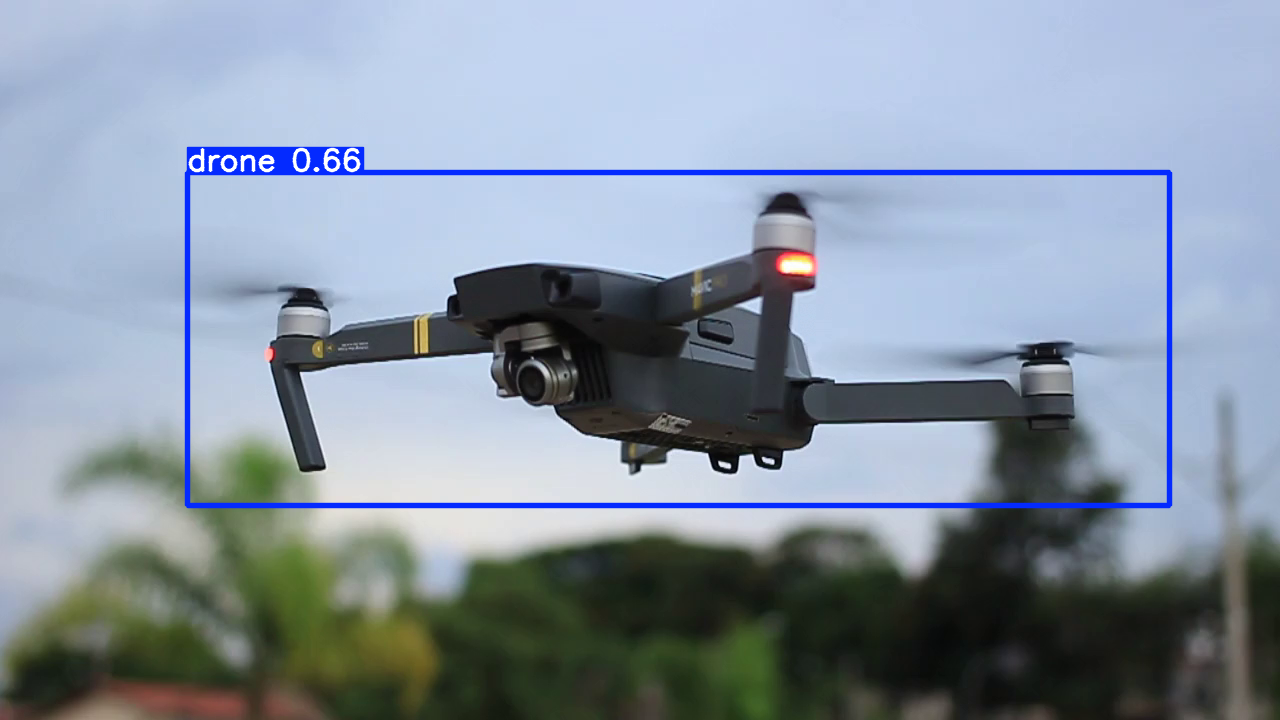

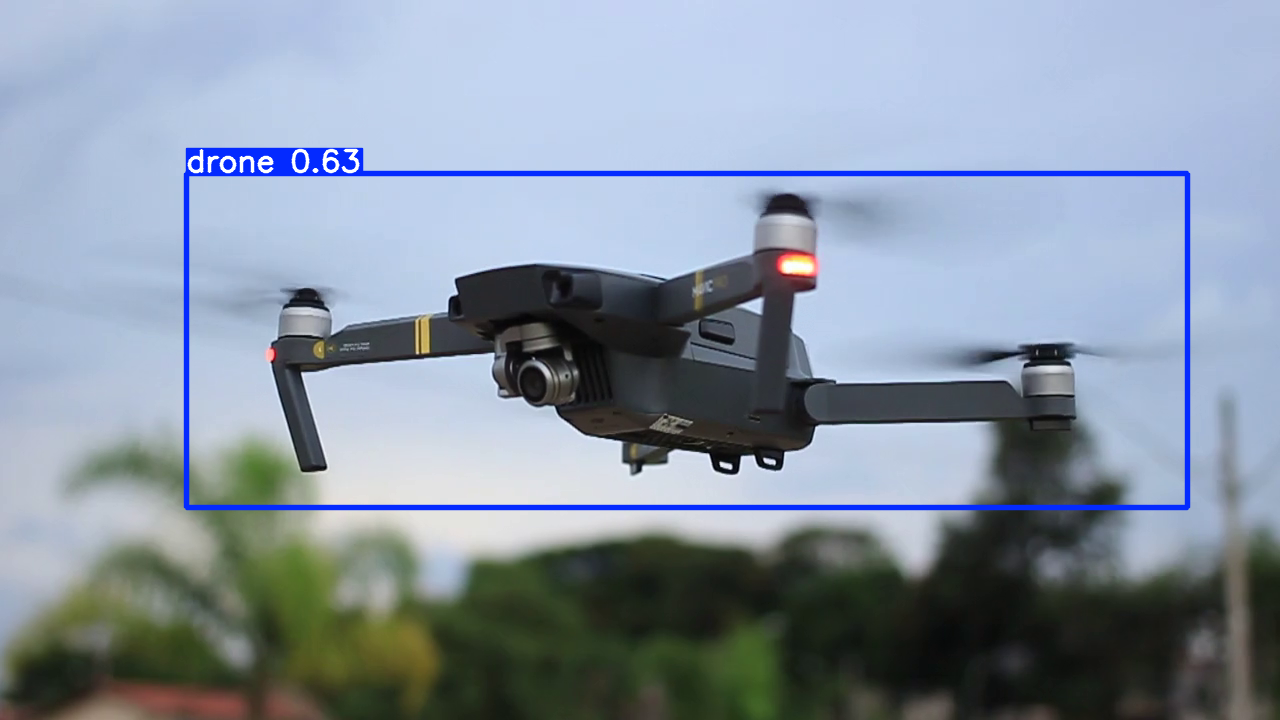

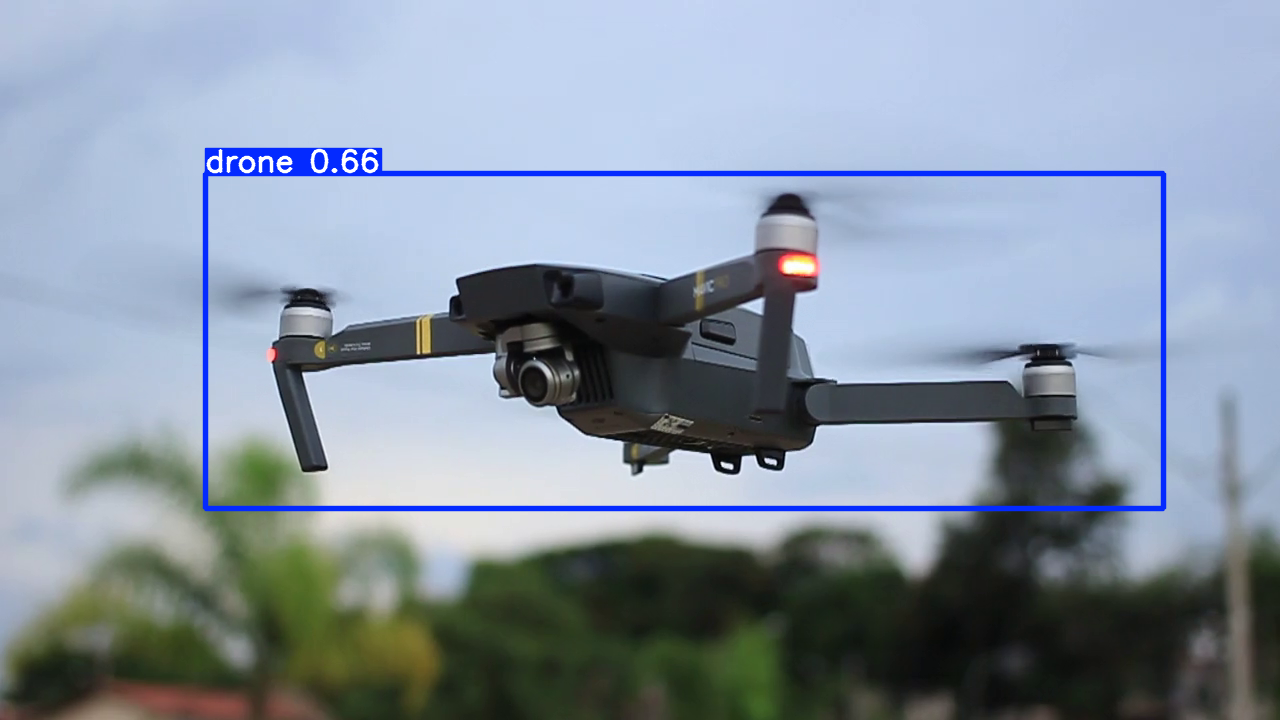

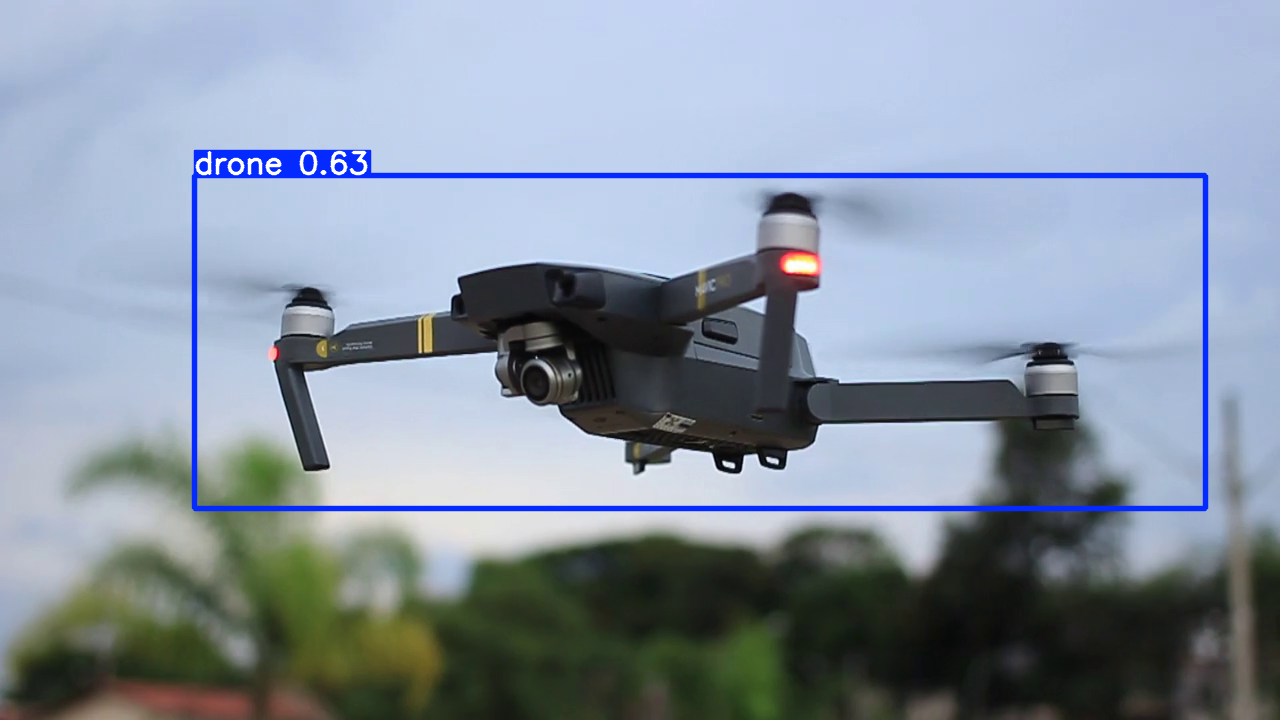

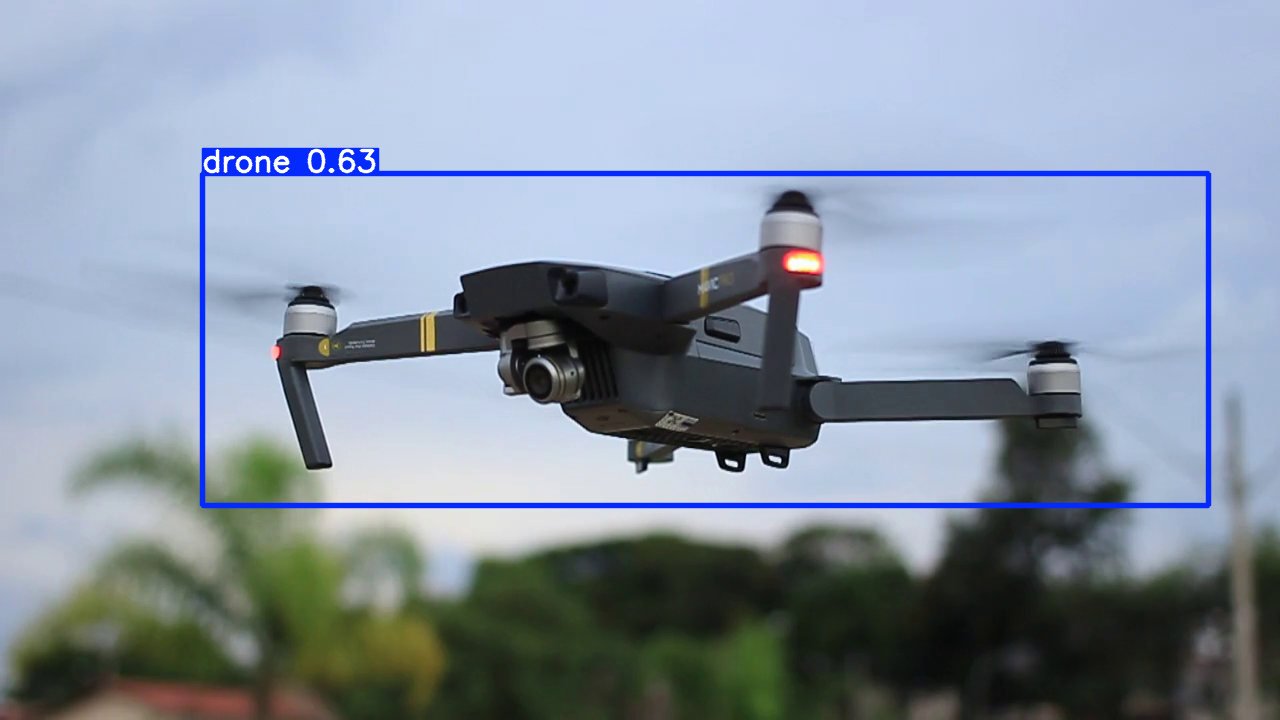

In [29]:
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import csv
from pathlib import Path
import cv2

# โหลดโมเดล
model = YOLO("best.pt")

# path ที่จะเซฟผลลัพธ์ CSV
csv_path = "results.csv"

# ถ้ายังไม่มีไฟล์ csv ให้สร้าง header
if not Path(csv_path).exists():
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "class", "confidence", "x_min", "y_min", "x_max", "y_max"])

# ทำนายวิดีโอและเซฟผลลัพธ์
results = model("test.mp4", save=True)

# วน loop ผลลัพธ์
frame_count = 0
max_frames_to_display = 5  # แสดงแค่บาง frame

for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()
    confs = r.boxes.conf.cpu().numpy()
    classes = r.boxes.cls.cpu().numpy()

    for box, conf, cls in zip(boxes, confs, classes):
        with open(csv_path, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([
                r.path if hasattr(r, "path") else "video_frame",
                model.names[int(cls)],
                float(conf),
                int(box[0]), int(box[1]), int(box[2]), int(box[3])
            ])

    # แสดงผล frame แรกๆ (ถ้ามีภาพอยู่ใน r.orig_img)
    if frame_count < max_frames_to_display and hasattr(r, "orig_img"):
        annotated = r.plot()  # Annotated frame
        cv2_imshow(annotated)
        frame_count += 1
